In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import matplotlib.image as mpimg
import PIL
import keras
import cv2

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
## Getting full images path library from dicom_info
df_dicom = pd.read_csv('./Data/csv/dicom_info.csv')
image_dir = './Data/jpeg'
all_images = df_dicom.image_path
all_images = all_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg',image_dir))


all_image_dict = dict()
for image in all_images:
    key = image.split('/')[3]
    all_image_dict[key] = image


In [3]:
print(len(all_image_dict))

6774


In [4]:
print(len(all_images))

10237


In [5]:
test_mass = pd.read_csv('./Data/csv/mass_case_description_test_set.csv')
test_calc = pd.read_csv('./Data/csv/calc_case_description_test_set.csv')

In [6]:
print(
    test_mass.shape,
    test_calc.shape,
    test_mass['image file path'].nunique(),
    test_calc['image file path'].nunique()
)

(378, 14) (326, 14) 361 284


In [7]:
test_mass.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [8]:
test_calc.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...


In [9]:
# Change column names without space
def column_name_no_space(table_name):
    new_columns = []
    for column in table_name.columns:
        new_columns.append(column.replace(' ', '_'))
    return new_columns
test_mass.columns = column_name_no_space(test_mass)
test_calc.columns = column_name_no_space(test_calc)

In [10]:
# Fix full image path in test mass and test c
def fix_img_path(df):
    for index, row in df.iterrows():
        image_name_f = row['image_file_path'].split('/')[2]
        if image_name_f in all_image_dict.keys():
            df.at[index, 'image_file_path'] = all_image_dict[image_name_f]
fix_img_path(test_mass)
fix_img_path(test_calc)

In [11]:
test_mass.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.245063149...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.859522146...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.221311896...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.239949064...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.215081818...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [12]:
test_mass.image_file_path

0      ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.245063149...
1      ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.859522146...
2      ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.221311896...
3      ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.239949064...
4      ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.215081818...
                             ...                        
373    ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.404577305...
374    ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.355464339...
375    ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.413066189...
376    ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.395806490...
377    ./Data/jpeg/1.3.6.1.4.1.9590.100.1.2.176004045...
Name: image_file_path, Length: 378, dtype: object

In [13]:
# Double check if image path is from destinated folder
def path_in_folder(df):
    base_dir = './Data/jpeg/'
    mask = (df['image_file_path'].str.startswith(base_dir)
    )
    filtered_df = df[mask]
    return filtered_df
test_mass=path_in_folder(test_mass)
test_calc=path_in_folder(test_calc)

In [14]:
print(test_mass.shape,test_calc.shape)

(378, 14) (326, 14)


In [15]:
test_mass.isnull().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  0
mass_margins               17
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64

In [16]:
test_calc.isnull().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
calc_type                   4
calc_distribution          63
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64

In [17]:
# Only save full image path and pathology for predicting
column_list = ['image_file_path','pathology']
test_mass[column_list].to_csv('./Data/Cleaned csv/Mass test cleaned.csv', index=False)  
test_calc[column_list].to_csv('./Data/Cleaned csv/Calc test cleaned.csv', index=False) 

Show few images from test mass and test calc

In [18]:
def display_images(df,column, number):
    # create figure and axes
    number_to_visualize = number
    max_columns = 5
    max_rows = 2
    rows = min(max_rows, -(-number_to_visualize // max_columns))
    cols = min(max_columns, number_to_visualize)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

    # Loop through rows and display images
    for index, row in df.head(number_to_visualize).iterrows():
        image_path = row[column]
        # Check if the file exists
        if os.path.exists(image_path):
            image = mpimg.imread(image_path)
            if rows == 1:
                ax = axes[index % cols]
            else:
                ax = axes[index // cols, index % cols]
            ax.imshow(image, cmap='gray')
            ax.set_title(f"{row['pathology']}")
            ax.axis('off')
        else:
            print(f"File not found: {image_path}")

    plt.tight_layout()
    plt.show()


Mass Testing Dataset


Full Mammograms:



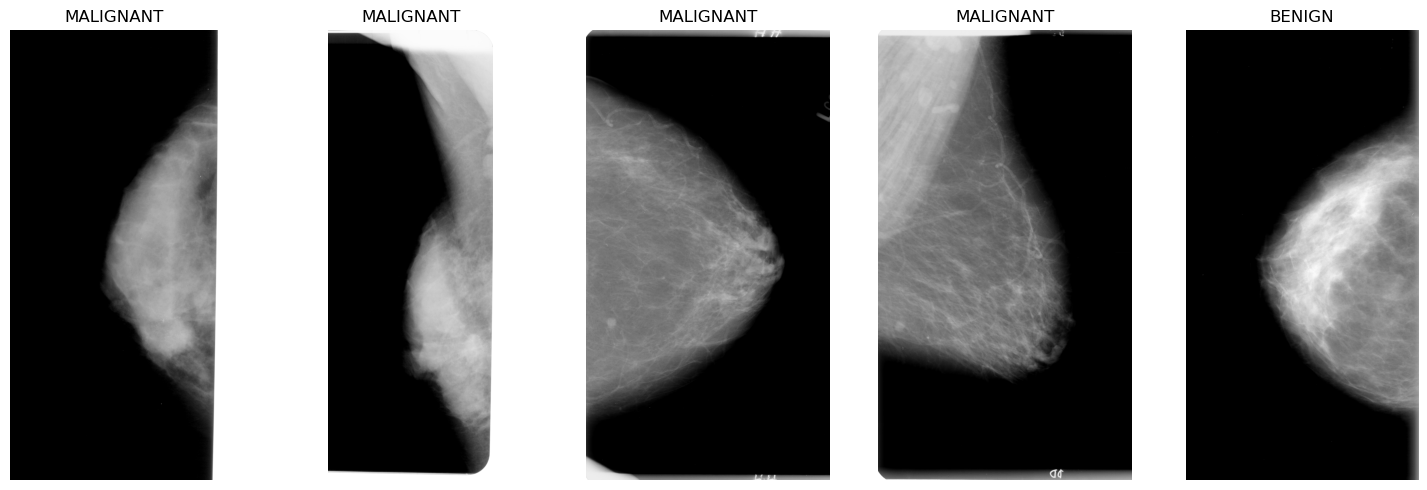

In [19]:
print('Mass Testing Dataset\n\n')
print('Full Mammograms:\n')
display_images(test_mass,'image_file_path', 5)


Calcification Testing Dataset


Full Mammograms:



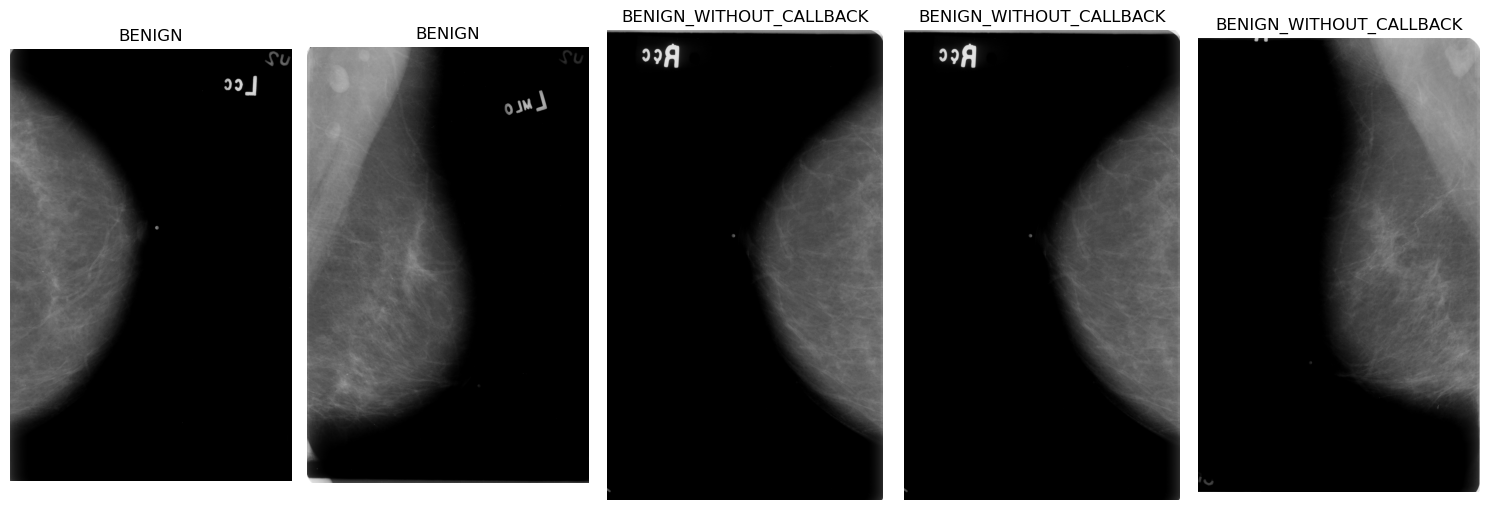

In [20]:
print('Calcification Testing Dataset\n\n')
print('Full Mammograms:\n')
display_images(test_calc,'image_file_path', 5)


Create Keras dataset for Testing data

In [21]:
mass_test = pd.read_csv('./Data/Cleaned csv/Mass test cleaned.csv')
calc_test = pd.read_csv('./Data/Cleaned csv/Calc test cleaned.csv')

In [22]:
full_image_path = mass_test['image_file_path']

for path in full_image_path:
    if not os.path.isfile(path):
        print(path)

In [23]:
full_image_path = calc_test['image_file_path']

for path in full_image_path:
    if not os.path.isfile(path):
        print(path)

In [24]:
mass_test['label'] = mass_test['pathology'].str.replace('_WITHOUT_CALLBACK','').apply(lambda x: x.lower())
calc_test['label'] = calc_test['pathology'].str.replace('_WITHOUT_CALLBACK','').apply(lambda x: x.lower())

In [25]:
def load_image_data(dataframe, image_column):
    # Create an ImageDataGenerator instance with rescaling
    datagen = ImageDataGenerator(rescale=1./255)

    # Generate image data using flow_from_dataframe
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=image_column,
        y_col='label',
        target_size=(512, 512),  # Specify the target size for images
        color_mode='rgb',
        batch_size=32,
        class_mode='binary',  # Set class_mode to None since there are no labels
        shuffle=False  # Keep the order of images the same as in the DataFrame
    )

    return generator


In [26]:
mass_test_img = load_image_data(mass_test, 'image_file_path')
calc_test_img = load_image_data(calc_test, 'image_file_path')

Found 378 validated image filenames belonging to 2 classes.
Found 326 validated image filenames belonging to 2 classes.


Loading model


In [27]:
my_model = tf.keras.models.load_model('./Model/my_cnn_model.keras')

In [31]:
mass_pred = my_model.predict(mass_test_img)

12/12 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step


In [70]:
threshold = 0.5
mass_pred_label = (mass_pred >= threshold).astype(int)

mass_test_labels = mass_test.label.map({'malignant': 1, 'benign': 0})

# Compute confusion matrix
mass_conf_matrix = confusion_matrix(mass_test_labels, mass_pred_label)

# F1 score
mass_f1 = f1_score(mass_test_labels, mass_pred_label)

In [72]:
print(f'Mass Test F1 Score',{round(mass_f1,3)})

Mass Test F1 Score {0.416}


<Figure size 800x600 with 0 Axes>

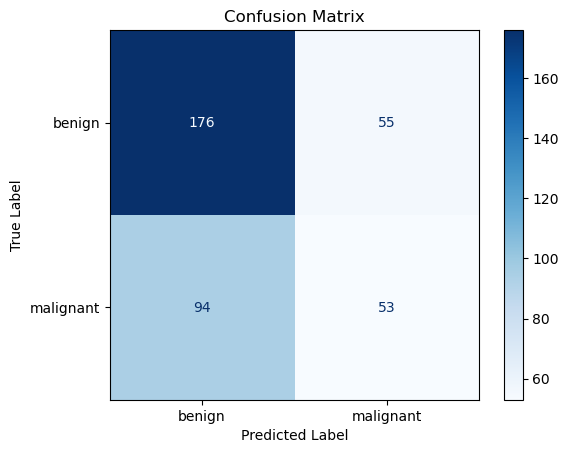

In [76]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(mass_conf_matrix, display_labels=np.unique(true_labels)).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('./Presentation/Figures/Mass Testing Confusion Matrics.jpg',dpi =200)
plt.show();

In [81]:
fpr, tpr, _ = roc_curve(mass_test_labels, mass_pred_label)
roc_auc = auc(fpr, tpr)

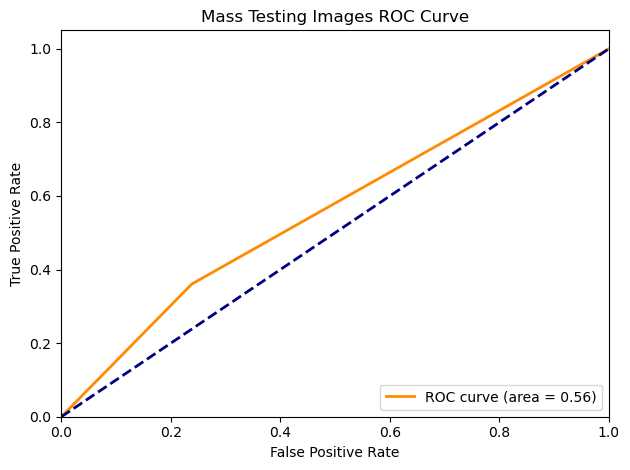

In [87]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mass Testing Images ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('./Presentation/Figures/ROC Curve for Mass Testing Images.jpg',dpi = 200)

In [65]:
calc_pred= my_model.predict(calc_test_img)

11/11 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step


In [73]:
calc_pred_label = (calc_pred >= threshold).astype(int)

calc_test_labels = calc_test.label.map({'malignant': 1, 'benign': 0})

# Compute confusion matrix
calc_conf_matrix = confusion_matrix(calc_test_labels, calc_pred_label)

# Calculate f1 score
calc_f1 = f1_score(calc_test_labels,calc_pred_label)

In [ ]:
calc_                                                                                                                                                                                                                                                                                                                                                           

<Figure size 800x600 with 0 Axes>

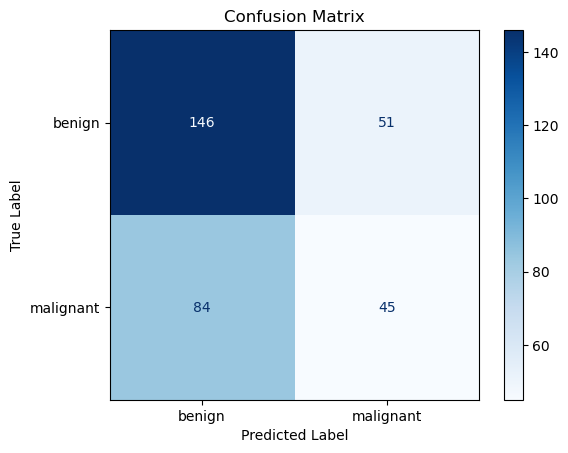

In [77]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(calc_conf_matrix, display_labels=np.unique(calc_true_labels)).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('./Presentation/Figures/Calcification Testing Confusion Matrics.jpg',dpi =200)
plt.show()

In [74]:
print(f'Calc Test F1 Score',{round(calc_f1,3)})

Calc Test F1 Score {0.4}


In [86]:
fprc, tprc, _ = roc_curve(calc_test_labels, calc_pred_label)
c_roc_auc = auc(fprc, fprc)

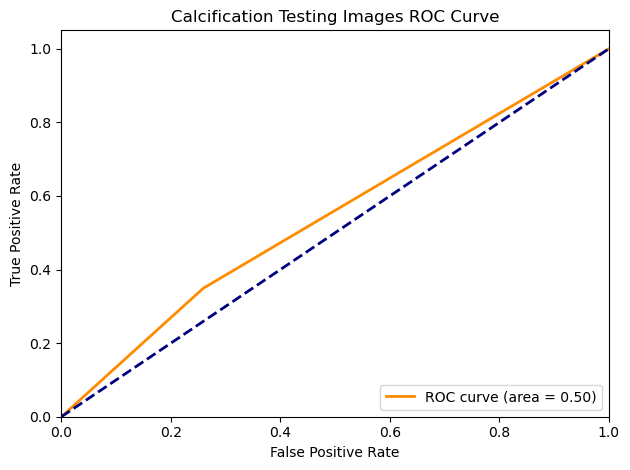

In [88]:
plt.figure()
plt.plot(fprc, tprc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % c_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Calcification Testing Images ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('./Presentation/Figures/ROC Curve for Calcification Testing Images.jpg',dpi = 200)